In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# Matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scipy for statistics
#import scipy


from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [2]:
# Dataframe to models
df_model_properties = pd.DataFrame({
    'Model':['linear_t','quad_t','SPPM_t','DPPM_t',
             'multlin_th','multquad_th','power_th',
             'multlin_tht','multquad_tht',
             'multlin_all','multquad_all',
             'multcub_all',
             'multquart_all'],
    
    'Features': [['t'],['t'],['t'],['t'],['t','h'],
                 ['t','h'],['t','h'],['t','h','T'],
                 ['t','h','T'],['t','h','T','A','W','H'],
                 ['t','h','T','A','W','G','H'],
                 ['t','h','T','A','W','G','H'],
                 ['t','h','T','A','W','G','H']],
    'MAE_test':['','','','','','','','','','','','',''],
    'R2_test':['','','','','','','','','','','','',''],
    'MAE_train':['','','','','','','','','','','','',''],
    'R2_train':['','','','','','','','','','','','','']
}).set_index('Model')


In [3]:
# Import Calories Dataset
df_cal = pd.read_csv(os.path.join('calories.csv'))

# Import Exercises Dataset
df_ex  = pd.read_csv(os.path.join('exercise.csv'))

# Merging Datasets
df = pd.merge(df_ex, df_cal, on = 'User_ID')
df.head()

# Get dummies
df['Gender'] = pd.get_dummies(df['Gender'], prefix_sep='_', drop_first=True)
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,1,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,0,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,1,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,0,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,0,27,154.0,58.0,10.0,81.0,39.8,35.0


Duration      0.955421
Heart_Rate    0.897882
Body_Temp     0.824558
Age           0.154395
Weight        0.035481
Gender        0.022357
Height        0.017537
Name: Calories, dtype: float64


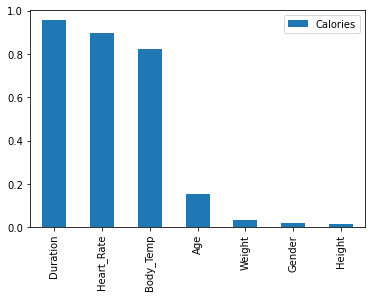

In [4]:
correlations = df.drop(columns=['User_ID'],axis=1).copy().corr()['Calories']
correlations = correlations.sort_values(ascending=False).drop('Calories',axis=0)
print(correlations)
correlations.to_frame().plot.bar();

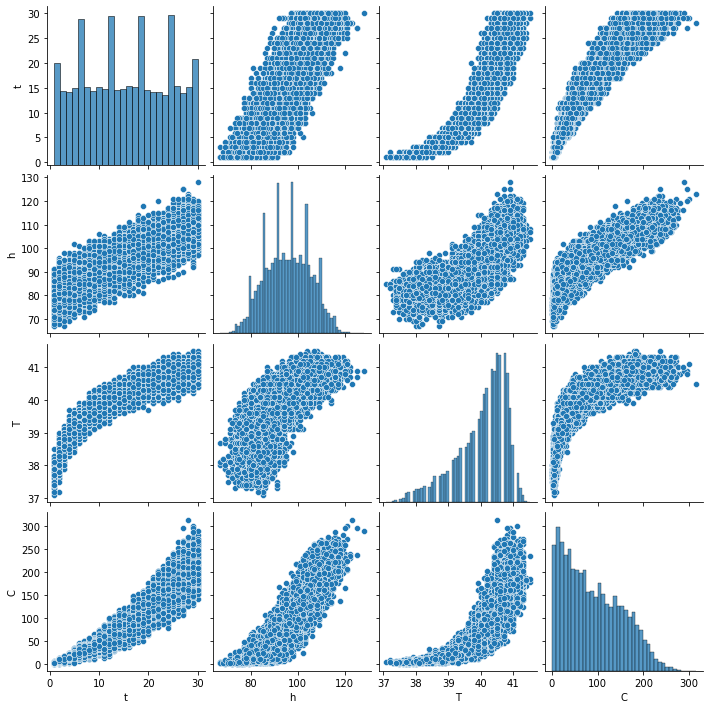

In [5]:
df_3f = df[['Duration','Heart_Rate','Body_Temp','Calories']].copy()
df_3f.rename(columns={'Duration':'t',
                      'Heart_Rate':'h',
                      'Body_Temp':'T',
                      'Calories':'C'},inplace=True)


df_6f = df[['Duration','Heart_Rate','Body_Temp','Age','Weight','Height','Calories']].copy()
df_6f.rename(columns={'Duration':'t',
                      'Heart_Rate':'h',
                      'Body_Temp':'T',
                      'Age':'A',
                      'Weight':'W',
                      'Height':'H',
                      'Calories':'C'},inplace=True)


df_7f = df[['Duration','Heart_Rate','Body_Temp','Age','Weight','Gender','Height','Calories']].copy()
df_7f.rename(columns={'Duration':'t',
                      'Heart_Rate':'h',
                      'Body_Temp':'T',
                      'Age':'A',
                      'Weight':'W',
                      'Gender':'G',
                      'Height':'H',
                      'Calories':'C'},inplace=True)

sns.pairplot(df_3f)

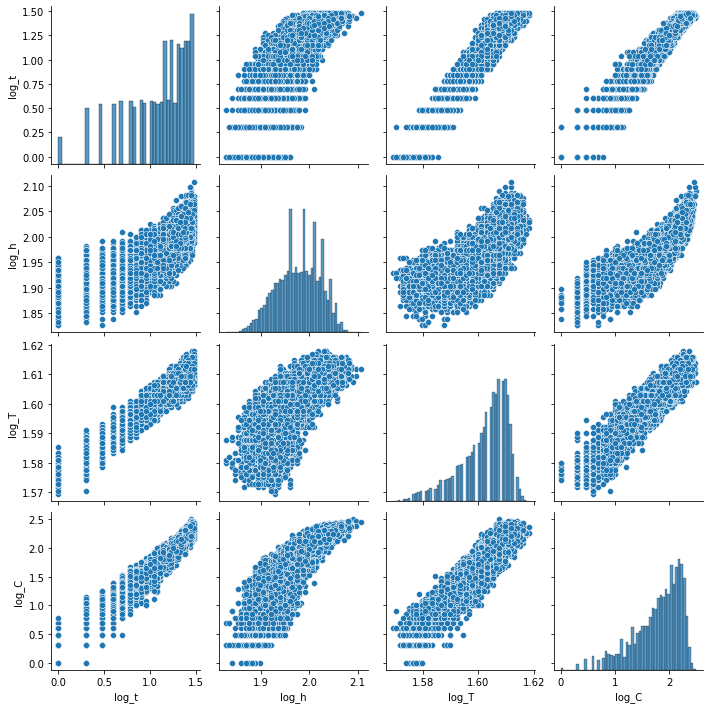

In [6]:
conditions = True
conditions &= df_3f['C'] > 0
conditions &= df_3f['t'] > 0

df_3f_log = np.log10(df_3f[conditions]).copy()

df_3f_log.rename(columns={'t':'log_t',
                      'h':'log_h',
                      'T':'log_T',
                      'C':'log_C'},inplace=True)

sns.pairplot(df_3f_log)

In [7]:
C_i = df_3f['C'].to_numpy()
t_i = df_3f['t'].to_numpy()
t_train, t_test, C_train, C_test = train_test_split(t_i, C_i, test_size=0.333, random_state=42)

logC_i = df_3f_log['log_C'].to_numpy()
logt_i = df_3f_log['log_t'].to_numpy()
logt_train, logt_test, logC_train, logC_test = train_test_split( logt_i, logC_i, test_size=0.333, random_state=42)

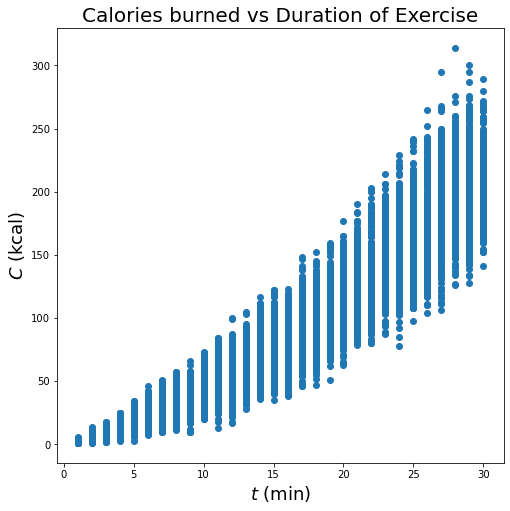

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(df_3f['t'],df_3f['C'])
plt.xlabel('$t$ (min)', size = 18)
plt.ylabel('$C$ (kcal)', size = 18)
plt.title('Calories burned vs Duration of Exercise', size = 20)
plt.show()

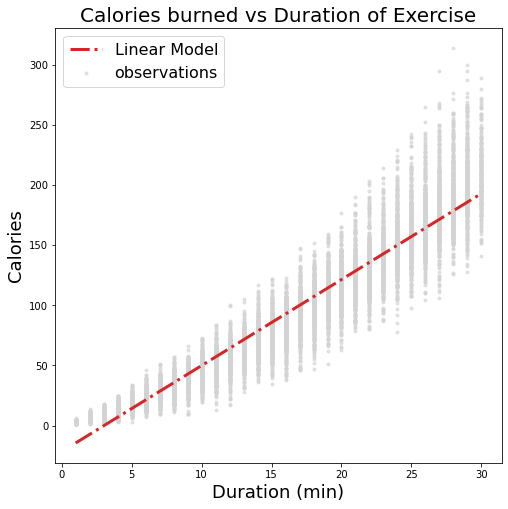

In [9]:
# Create a lineat regression object
lin_reg = linear_model.LinearRegression()

# Train the model using the training sets
lin_reg.fit(t_train.reshape(-1,1)   ,C_train.reshape(-1,1))

# Selecting a interval for duration
t_val = np.linspace(t_i.min(),t_i.max(),100)

# Predicting
C_lin_model = lin_reg.predict(t_val.reshape(-1,1))

# Plotting and comparing
plt.figure(figsize=(8, 8))
plt.scatter(df['Duration'],df['Calories'],c='lightgray',label = 'observations',alpha = 0.6,marker='.',zorder=1)
plt.plot(t_val,C_lin_model, c='tab:red',ls='-.', label = 'Linear Model', lw = 3,zorder=2)
plt.xlabel('Duration (min)', size = 18)
plt.ylabel('Calories', size = 18); 
plt.legend(prop={'size': 16})
plt.title('Calories burned vs Duration of Exercise', size = 20);


In [10]:
# Predictions for the test set
C_lin_test = lin_reg.predict(t_test.reshape(-1,1))

# Predictions for the train set
C_lin_train = lin_reg.predict(t_train.reshape(-1,1))

# Filling dataframe
df_model_properties.loc['linear_t']['MAE_test'] = mean_absolute_error(C_lin_test,C_test)
df_model_properties.loc['linear_t']['R2_test'] = r2_score(C_lin_test,C_test)
df_model_properties.loc['linear_t']['MAE_train'] = mean_absolute_error(C_lin_train,C_train)
df_model_properties.loc['linear_t']['R2_train'] = r2_score(C_lin_train,C_train)

# Printing  results
print('Mean error (test): ',df_model_properties.loc['linear_t']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['linear_t']['R2_test'])


print('\nMean error (train): ',df_model_properties.loc['linear_t']['MAE_train'])
print('R2 (train):  ',df_model_properties.loc['linear_t']['R2_train'])

Mean error (test):  13.593873543531657
R2 (test):     0.9026309937324182

Mean error (train):  13.502767761900637
R2 (train):   0.904407384423175


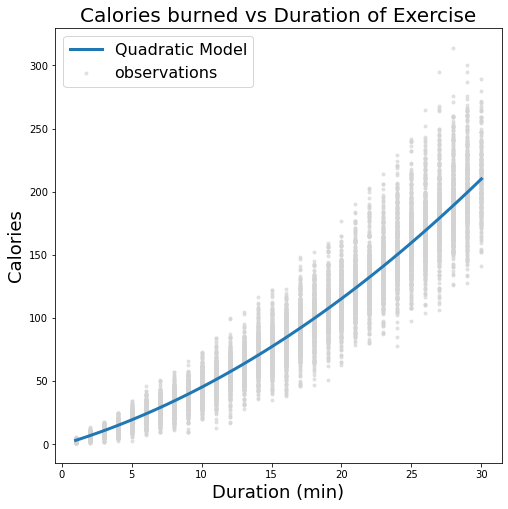

In [11]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

# Create a linear regression object
quad_reg = linear_model.LinearRegression()

# Reshaping feature
T_train = t_train.reshape(-1,1)

# Transfomr features to a polynomial regression
quad = PolynomialFeatures(degree=2)
T_train_quad = quad.fit_transform(T_train)

# Training
quad_reg.fit(T_train_quad ,C_train.reshape(-1,1))

# Selecting a interval for duration an adapting shape
T_val = np.linspace(t_i.min(),t_i.max(),100).reshape(-1,1)
T_val_quad = quad.fit_transform(T_val)

# Predicting values
C_quad_model = quad_reg.predict(T_val_quad)

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(df['Duration'],df['Calories'],c='lightgray',label = 'observations',alpha = 0.6,marker='.',zorder=1)
plt.plot(t_val,C_quad_model, label = 'Quadratic Model', c='tab:blue', lw = 3,zorder=2)
plt.xlabel('Duration (min)', size = 18)
plt.ylabel('Calories', size = 18); 
plt.legend(prop={'size': 16})
plt.title('Calories burned vs Duration of Exercise', size = 20);

In [12]:
C_quad_test = quad_reg.predict(quad.fit_transform(t_test.reshape(-1,1)))
C_quad_train = quad_reg.predict(quad.fit_transform(t_train.reshape(-1,1)))

df_model_properties.loc['quad_t']['MAE_test'] = mean_absolute_error(C_quad_test,C_test)
df_model_properties.loc['quad_t']['R2_test'] = r2_score(C_quad_test,C_test)
df_model_properties.loc['quad_t']['MAE_train'] = mean_absolute_error(C_quad_train,C_train)
df_model_properties.loc['quad_t']['R2_train'] = r2_score(C_quad_train,C_train)


print('Mean error (test): ',df_model_properties.loc['quad_t']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['quad_t']['R2_test'])

print('\nMean error (train): ',df_model_properties.loc['quad_t']['MAE_train'])
print('R2 (train):  ',df_model_properties.loc['quad_t']['R2_train'])



Mean error (test):  11.365273283651957
R2 (test):     0.9235407715434064

Mean error (train):  11.344388456602674
R2 (train):   0.9225497042024959


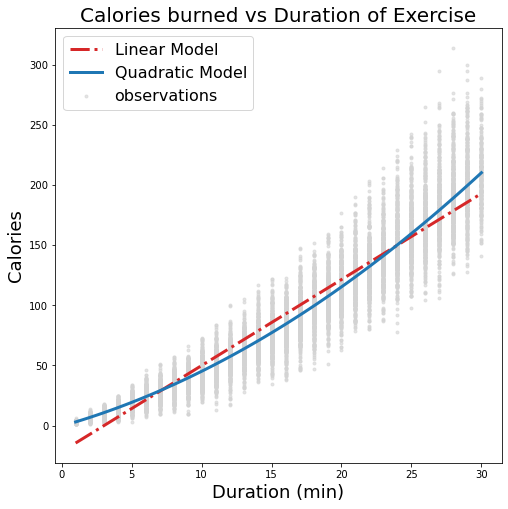

In [13]:
plt.figure(figsize=(8, 8))
plt.scatter(df['Duration'],df['Calories'],c='lightgray',label = 'observations',alpha = 0.6,marker='.',zorder=1)
plt.plot(t_val,C_lin_model, c='tab:red',ls='-.', label = 'Linear Model', lw = 3,zorder=2)
plt.plot(t_val,C_quad_model, label = 'Quadratic Model', c='tab:blue', lw = 3,zorder=2)
plt.xlabel('Duration (min)', size = 18)
plt.ylabel('Calories', size = 18); 
plt.legend(prop={'size': 16})
plt.title('Calories burned vs Duration of Exercise', size = 20);


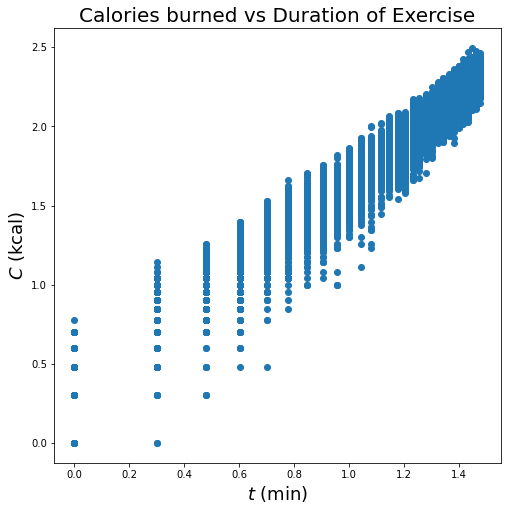

In [14]:
plt.figure(figsize=(8,8))
plt.scatter(df_3f_log['log_t'],df_3f_log['log_C'])
plt.xlabel('$t$ (min)', size = 18)
plt.ylabel('$C$ (kcal)', size = 18)
plt.title('Calories burned vs Duration of Exercise', size = 20)
plt.show()


In [15]:
# In fact, this is the only calculation for this method
c_1 = np.dot(logC_train,logt_train)/np.dot(logt_train,logt_train)

print('The value of c_1 is: ',c_1)

# With the value of c1, its possible to define a predict function
def sing_par_predict(t,c1 = c_1):
    return np.power(t,c1) 

The value of c_1 is:  1.6065812051542225


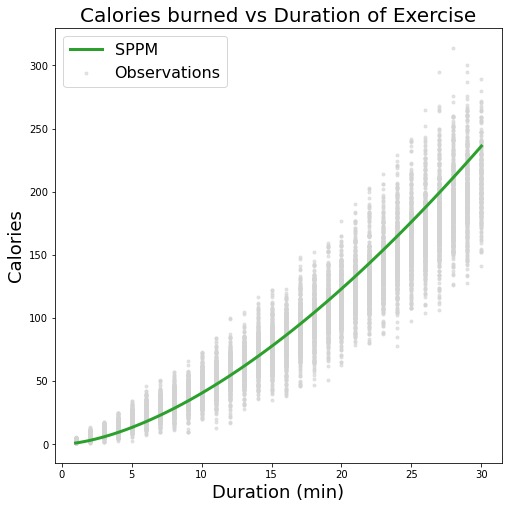

In [16]:
t_val = np.linspace(t_i.min(),t_i.max(),100)
C_sing = sing_par_predict(t_val)

plt.figure(figsize=(8, 8))
plt.scatter(df['Duration'],df['Calories'],c='lightgray',label = 'Observations',alpha = 0.6,marker='.',zorder=1)
plt.plot(t_val,C_sing, c='tab:green',ls='-', label = 'SPPM', linewidth = 3)
plt.xlabel('Duration (min)', size = 18)
plt.ylabel('Calories', size = 18); 
plt.legend(prop={'size': 16})
plt.title('Calories burned vs Duration of Exercise', size = 20);


In [17]:
C_sppm_test = sing_par_predict(t_test)
C_sppm_train = sing_par_predict(t_train)

df_model_properties.loc['SPPM_t']['MAE_test'] = mean_absolute_error(C_sppm_test,C_test)
df_model_properties.loc['SPPM_t']['R2_test'] = r2_score(C_sppm_test,C_test)
df_model_properties.loc['SPPM_t']['MAE_train'] = mean_absolute_error(C_sppm_train,C_train)
df_model_properties.loc['SPPM_t']['R2_train'] = r2_score(C_sppm_train,C_train)

print('Mean error (test): ',df_model_properties.loc['SPPM_t']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['SPPM_t']['R2_test'])


print('\nMean error (train): ',df_model_properties.loc['SPPM_t']['MAE_train'])
print('R2 (train):  ',df_model_properties.loc['SPPM_t']['R2_train'])


Mean error (test):  14.1125272648781
R2 (test):     0.9221687473557441

Mean error (train):  14.301879510269131
R2 (train):   0.9186682788191453


In [18]:
# Create a linear regression object
log_reg = linear_model.LinearRegression()

# Train the model using the training sets
log_reg.fit(logt_train.reshape(-1,1),logC_train.reshape(-1,1))

logC_pred = log_reg.predict(logt_test.reshape(-1,1))

def dbl_par_predict(t):
    logt = np.log10(t)
    return  np.power(10,log_reg.predict(logt)) 

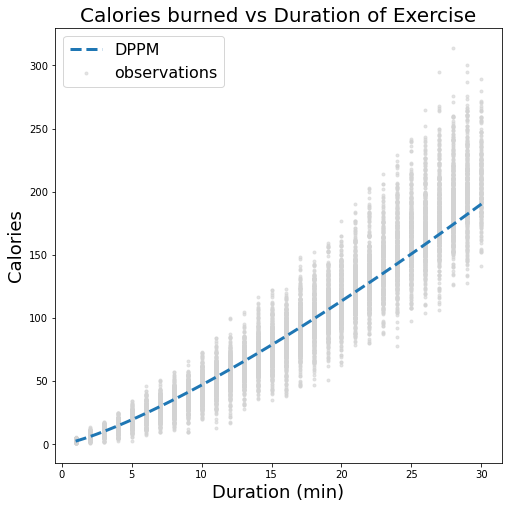

In [19]:
t_val = np.linspace(t_i.min(),t_i.max(),100)
C_log_model = dbl_par_predict(t_val.reshape(-1,1))
plt.figure(figsize=(8, 8))
plt.scatter(df['Duration'],df['Calories'],c='lightgray',label = 'observations',alpha = 0.6,marker='.',zorder=1)
plt.plot(t_val,C_log_model, c='tab:blue',ls='--', label = 'DPPM', lw = 3,zorder=2)
plt.xlabel('Duration (min)', size = 18)
plt.ylabel('Calories', size = 18); 
plt.legend(prop={'size': 16})
plt.title('Calories burned vs Duration of Exercise', size = 20);

In [20]:
C_dppm_test = dbl_par_predict(t_test.reshape(-1,1))
C_dppm_train = dbl_par_predict(t_train.reshape(-1,1))


df_model_properties.loc['DPPM_t']['MAE_test'] = mean_absolute_error(C_dppm_test,C_test)
df_model_properties.loc['DPPM_t']['R2_test'] = r2_score(C_dppm_test,C_test)
df_model_properties.loc['DPPM_t']['MAE_train'] = mean_absolute_error(C_dppm_train,C_train)
df_model_properties.loc['DPPM_t']['R2_train'] = r2_score(C_dppm_train,C_train)


print('Mean error (test): ',df_model_properties.loc['DPPM_t']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['DPPM_t']['R2_test'])


print('\nMean error (train): ',df_model_properties.loc['DPPM_t']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['DPPM_t']['R2_test'])


print('\nMean error (train): ',df_model_properties.loc['DPPM_t']['MAE_train'])
print('R2 (train):  ',df_model_properties.loc['DPPM_t']['R2_train'])

Mean error (test):  12.021118154420325
R2 (test):     0.8917909397979026

Mean error (train):  12.021118154420325
R2 (test):     0.8917909397979026

Mean error (train):  11.820742431418886
R2 (train):   0.8947519321424061


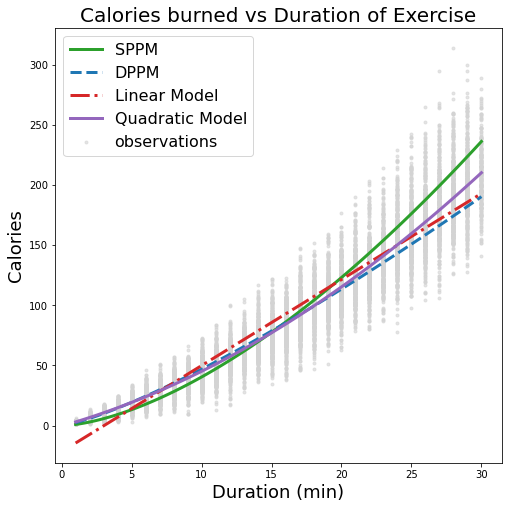

In [21]:
t_val = np.linspace(t_i.min(),t_i.max(),100)
C_lin_model = lin_reg.predict(t_val.reshape(-1,1))
C_log_model = dbl_par_predict(t_val.reshape(-1,1))
plt.figure(figsize=(8, 8))
plt.scatter(df['Duration'],df['Calories'],c='lightgray',label = 'observations',alpha = 0.6,marker='.',zorder=1)
plt.plot(t_val,C_sing, c='tab:green',ls='-', label = 'SPPM', lw = 3,zorder=2)
plt.plot(t_val,C_log_model, c='tab:blue',ls='--', label = 'DPPM', lw = 3,zorder=2)
plt.plot(t_val,C_lin_model, c='tab:red',ls='-.', label = 'Linear Model', lw = 3,zorder=2)
plt.plot(t_val,C_quad_model, label = 'Quadratic Model', c='tab:purple', lw = 3,zorder=2)
plt.xlabel('Duration (min)', size = 18)
plt.ylabel('Calories', size = 18); 
plt.legend(prop={'size': 16})
plt.title('Calories burned vs Duration of Exercise', size = 20);

In [22]:
# Organization of dataset
TH_i = df_3f[['t','h']].to_numpy()
C_i = df_3f['C'].to_numpy().reshape(-1,1)
TH_trn, TH_tst, C_trn, C_tst = train_test_split( TH_i,C_i, test_size=0.333, random_state=42)

# Organization of log dataset
logTH_i = df_3f_log[['log_t','log_h']].to_numpy()
logC_i = df_3f_log['log_C'].to_numpy().reshape(-1,1)
logTH_trn, logTH_tst, logC_trn, logC_tst = train_test_split(logTH_i,logC_i,test_size=0.333, random_state=42)

In [23]:
# Create regression object
ML2 = linear_model.LinearRegression()

# Train the model using the training sets
ML2.fit(TH_trn,C_trn)

# Predicting for test and train
C_ml2_tst = ML2.predict(TH_tst)
C_ml2_trn = ML2.predict(TH_trn)

# Updating results dataframe
df_model_properties.loc['multlin_th']['MAE_test'] = mean_absolute_error(C_tst,C_ml2_tst)
df_model_properties.loc['multlin_th']['R2_test'] = r2_score(C_tst,C_ml2_tst)
df_model_properties.loc['multlin_th']['MAE_train'] = mean_absolute_error(C_trn,C_ml2_trn)
df_model_properties.loc['multlin_th']['R2_train'] = r2_score(C_trn,C_ml2_trn)

# Showing
print('Mean error (test): ',df_model_properties.loc['multlin_th']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['multlin_th']['R2_test'])
print('\nMean error (train): ',df_model_properties.loc['multlin_th']['MAE_train'])
print('R2 (train):  ',df_model_properties.loc['multlin_th']['R2_train'])

Mean error (test):  11.66771806962942
R2 (test):     0.936710281164849

Mean error (train):  11.493310827379922
R2 (train):   0.9388026851404877


In [24]:
MQ2 = linear_model.LinearRegression()

MQ2_poly = PolynomialFeatures(degree=2)

TH_trn_pl = MQ2_poly.fit_transform(TH_trn)

TH_tst_pl = MQ2_poly.fit_transform(TH_tst)

MQ2.fit(TH_trn_pl,C_trn)

C_mq2_tst = MQ2.predict(TH_tst_pl)

C_mq2_trn = MQ2.predict(TH_trn_pl)

df_model_properties.loc['multquad_th']['MAE_test'] = mean_absolute_error(C_tst,C_mq2_tst)
df_model_properties.loc['multquad_th']['R2_test'] = r2_score(C_tst,C_mq2_tst)
df_model_properties.loc['multquad_th']['MAE_train'] = mean_absolute_error(C_trn,C_mq2_trn)
df_model_properties.loc['multquad_th']['R2_train'] = r2_score(C_trn,C_mq2_trn)

print('Mean error (test): ',df_model_properties.loc['multquad_th']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['multquad_th']['R2_test'])

print('\nMean error (train): ',df_model_properties.loc['multquad_th']['MAE_train'])
print('R2 (train):  ',df_model_properties.loc['multquad_th']['R2_train'])

Mean error (test):  8.296957448492856
R2 (test):     0.9610619558653577

Mean error (train):  8.137972011298205
R2 (train):   0.9624337462717035


In [25]:
MP1 = linear_model.LinearRegression()

MP1.fit(logTH_trn,logC_trn)

def power_pth_predict(TH):
    logTH = np.log10(TH)
    return  np.power(10,MP1.predict(logTH))

In [26]:
C_mp1_tst = power_pth_predict(TH_tst)
C_mp1_trn = power_pth_predict(TH_trn)

df_model_properties.loc['power_th']['MAE_test'] = mean_absolute_error(C_tst,C_mp1_tst)
df_model_properties.loc['power_th']['R2_test'] = r2_score(C_tst,C_mp1_tst)

df_model_properties.loc['power_th']['MAE_train'] = mean_absolute_error(C_trn,C_mp1_trn)
df_model_properties.loc['power_th']['R2_train'] = r2_score(C_trn,C_mp1_trn)


print('Mean error (test): ',df_model_properties.loc['power_th']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['power_th']['R2_test'])

print('\nMean error (train): ',df_model_properties.loc['power_th']['MAE_train'])
print('R2 (train):  ',df_model_properties.loc['power_th']['R2_train'])

Mean error (test):  8.598564469552057
R2 (test):     0.9594573580056064

Mean error (train):  8.449130114442292
R2 (train):   0.9604518661920015


In [27]:
THT_i = df_3f[['t','h','T']].to_numpy()
C_i = df_3f['C'].to_numpy().reshape(-1,1)
THT_trn, THT_tst, C_trn, C_tst = train_test_split( THT_i,C_i, test_size=0.333, random_state=42)

logTHT_i = df_3f_log[['log_t','log_h','log_T']].to_numpy()
logC_i = df_3f_log['log_C'].to_numpy().reshape(-1,1)
logTHT_trn, logTHT_tst, logC_trn, logC_tst = train_test_split(logTHT_i,logC_i,test_size=0.333, random_state=42)

In [28]:
# Create regression object
ML3 = linear_model.LinearRegression()

# Train the model using the training sets
ML3.fit(THT_trn,C_trn)

C_ml3_tst = ML3.predict(THT_tst)
C_ml3_trn = ML3.predict(THT_trn)


df_model_properties.loc['multlin_tht']['MAE_test'] = mean_absolute_error(C_tst,C_ml3_tst)
df_model_properties.loc['multlin_tht']['R2_test'] = r2_score(C_tst,C_ml3_tst)

df_model_properties.loc['multlin_tht']['MAE_train'] = mean_absolute_error(C_trn,C_ml3_trn)
df_model_properties.loc['multlin_tht']['R2_train'] = r2_score(C_trn,C_ml3_trn)


print('Mean error (test): ',df_model_properties.loc['multlin_tht']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['multlin_tht']
['R2_test'])

print('\nMean error (train): ',df_model_properties.loc['multlin_tht']['MAE_train'])
print('R2 (train):  ',df_model_properties.loc['multlin_tht']['R2_train'])

Mean error (test):  10.647808909098174
R2 (test):     0.9451629732671258

Mean error (train):  10.516353537121516
R2 (train):   0.9467824214841805


In [29]:
# Create regression object
MQ3 = linear_model.LinearRegression()

MQ3_poly = PolynomialFeatures(degree=2)
THT_trn_pl = MQ3_poly.fit_transform(THT_trn)
THT_tst_pl = MQ3_poly.fit_transform(THT_tst)


# Train the model using the training sets
MQ3.fit(THT_trn_pl,C_trn)

C_mq3_tst = MQ3.predict(THT_tst_pl)
C_mq3_trn = MQ3.predict(THT_trn_pl)

df_model_properties.loc['multquad_tht']['MAE_test'] = mean_absolute_error(C_tst,C_mq3_tst)
df_model_properties.loc['multquad_tht']['R2_test'] = r2_score(C_tst,C_mq3_tst)

df_model_properties.loc['multquad_tht']['MAE_train'] = mean_absolute_error(C_trn,C_mq3_trn)
df_model_properties.loc['multquad_tht']['R2_train'] = r2_score(C_trn,C_mq3_trn)

print('Mean error (test): ',df_model_properties.loc['multquad_tht']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['multquad_tht']['R2_test'])

print('\nMean error (train): ',df_model_properties.loc['multquad_tht']['MAE_train'])
print('R2 (train):  ',df_model_properties.loc['multquad_tht']['R2_train'])

Mean error (test):  8.307127256866414
R2 (test):     0.9610771458585452

Mean error (train):  8.142429869734924
R2 (train):   0.9624488806614029


In [30]:
X_i = df_7f[['t','h','T','A','W','G','H']].to_numpy()
C_i = df_7f['C'].to_numpy().reshape(-1,1)
X_trn, X_tst, C_trn, C_tst = train_test_split( X_i,C_i, test_size=0.333, random_state=42)

In [31]:
# Create regression object
ML6 = linear_model.LinearRegression()

# Train the model using the training sets
ML6.fit(X_trn,C_trn)

C_ml6_tst = ML6.predict(X_tst)
C_ml6_trn = ML6.predict(X_trn)


df_model_properties.loc['multlin_all']['MAE_test'] = mean_absolute_error(C_tst,C_ml6_tst)
df_model_properties.loc['multlin_all']['R2_test'] = r2_score(C_tst,C_ml6_tst)

df_model_properties.loc['multlin_all']['MAE_train'] = mean_absolute_error(C_trn,C_ml6_trn)
df_model_properties.loc['multlin_all']['R2_train'] = r2_score(C_trn,C_ml6_trn)

print('Mean error (test): ',df_model_properties.loc['multlin_all']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['multlin_all']['R2_test'])

print('\nMean error (train): ',df_model_properties.loc['multlin_all']['MAE_train'])
print('R2 (train):  ',df_model_properties.loc['multlin_all']['R2_train'])

Mean error (test):  8.437652846858738
R2 (test):     0.9664081290862842

Mean error (train):  8.28158203316544
R2 (train):   0.9675871034049008


In [32]:
# Create regression object
MQ6 = linear_model.LinearRegression()

MQ6_poly = PolynomialFeatures(degree=2)
X_trn_pl = MQ6_poly.fit_transform(X_trn)
X_tst_pl = MQ6_poly.fit_transform(X_tst)


# Train the model using the training sets
MQ6.fit(X_trn_pl,C_trn)

C_mq6_tst = MQ6.predict(X_tst_pl)
C_mq6_trn = MQ6.predict(X_trn_pl)

df_model_properties.loc['multquad_all']['MAE_test'] = mean_absolute_error(C_tst,C_mq6_tst)
df_model_properties.loc['multquad_all']['R2_test'] = r2_score(C_tst,C_mq6_tst)

df_model_properties.loc['multquad_all']['MAE_train'] = mean_absolute_error(C_trn,C_mq6_trn)
df_model_properties.loc['multquad_all']['R2_train'] = r2_score(C_trn,C_mq6_trn)

print('Mean error (test): ',df_model_properties.loc['multquad_all']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['multquad_all']['R2_test'])

print('\nMean error (train): ',df_model_properties.loc['multquad_all']['MAE_train'])
print('R2 (train):  ',df_model_properties.loc['multquad_all']['R2_train'])

Mean error (test):  2.2366276754649896
R2 (test):     0.9976665498106837

Mean error (train):  2.2019157554839164
R2 (train):   0.9977285590395195


In [33]:
# Create regression object
MQ6 = linear_model.LinearRegression()

MQ6_poly = PolynomialFeatures(degree=3)
X_trn_pl = MQ6_poly.fit_transform(X_trn)
X_tst_pl = MQ6_poly.fit_transform(X_tst)


# Train the model using the training sets
MQ6.fit(X_trn_pl,C_trn)

C_mq6_tst = MQ6.predict(X_tst_pl)
C_mq6_trn = MQ6.predict(X_trn_pl)

df_model_properties.loc['multcub_all']['MAE_test'] = mean_absolute_error(C_tst,C_mq6_tst)
df_model_properties.loc['multcub_all']['R2_test'] = r2_score(C_tst,C_mq6_tst)

df_model_properties.loc['multcub_all']['MAE_train'] = mean_absolute_error(C_trn,C_mq6_trn)
df_model_properties.loc['multcub_all']['R2_train'] = r2_score(C_trn,C_mq6_trn)

print('Mean error (test): ',df_model_properties.loc['multcub_all']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['multcub_all']['R2_test'])

print('\nMean error (train): ',df_model_properties.loc['multcub_all']['MAE_train'])
print('R2 (train):  ',df_model_properties.loc['multcub_all']['R2_train'])

Mean error (test):  0.2538225560410548
R2 (test):     0.9999782665063686

Mean error (train):  0.2504124453809609
R2 (train):   0.9999784303299277


In [34]:
# Create regression object
MQ6 = linear_model.LinearRegression()

MQ6_poly = PolynomialFeatures(degree=4)
X_trn_pl = MQ6_poly.fit_transform(X_trn)
X_tst_pl = MQ6_poly.fit_transform(X_tst)


# Train the model using the training sets
MQ6.fit(X_trn_pl,C_trn)

C_mq6_tst = MQ6.predict(X_tst_pl)
C_mq6_trn = MQ6.predict(X_trn_pl)

df_model_properties.loc['multquart_all']['MAE_test'] = mean_absolute_error(C_tst,C_mq6_tst)
df_model_properties.loc['multquart_all']['R2_test'] = r2_score(C_tst,C_mq6_tst)

df_model_properties.loc['multquart_all']['MAE_train'] = mean_absolute_error(C_trn,C_mq6_trn)
df_model_properties.loc['multquart_all']['R2_train'] = r2_score(C_trn,C_mq6_trn)


print('Mean error (test): ',df_model_properties.loc['multquart_all']['MAE_test'])
print('R2 (test):    ',df_model_properties.loc['multquart_all']['R2_test'])

print('\nMean error (train): ',df_model_properties.loc['multquart_all']['MAE_train'])
print('R2 (train):  ',df_model_properties.loc['multquart_all']['R2_train'])

Mean error (test):  0.2552376726051544
R2 (test):     0.999977860786347

Mean error (train):  0.2471590151949434
R2 (train):   0.9999788446640118


In [35]:
df_model_properties

,Features,MAE_test,R2_test,MAE_train,R2_train
Model,,,,,
linear_t,[t],13.593874,0.902631,13.502768,0.904407
quad_t,[t],11.365273,0.923541,11.344388,0.92255
SPPM_t,[t],14.112527,0.922169,14.30188,0.918668
DPPM_t,[t],12.021118,0.891791,11.820742,0.894752
multlin_th,"[t, h]",11.667718,0.93671,11.493311,0.938803
multquad_th,"[t, h]",8.296957,0.961062,8.137972,0.962434
power_th,"[t, h]",8.598564,0.959457,8.44913,0.960452
multlin_tht,"[t, h, T]",10.647809,0.945163,10.516354,0.946782
multquad_tht,"[t, h, T]",8.307127,0.961077,8.14243,0.962449
